In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [116]:
mass = 'm00'
runname = '6f_overguide_' + mass
datadir = f'/Volumes/pavonis/Roman/filter_choice/filter_selection/6f_overguide_{mass}/analysis/' 

ostore = pd.HDFStore(datadir + '%s.out.hdf5' % (runname),'r')
out = ostore.select('out')
plt.figure()
plt.hist(np.log10(out['Planet_semimajoraxis']),range=[np.log10(0.03),np.log10(300)],bins=50)
plt.show()
ostore.close()

plt.figure()
plt.scatter(np.log10(out['Planet_semimajoraxis']),out['Planet_s'],s=1)
plt.yscale('log')
plt.show()


In [150]:
import json

with open('/Users/penny/synthpop-public/synthpop/config_files/AAA_effective_wavelengths.json') as f:
    elambda = json.load(f)

def Al_Ar(filt,R_V=2.5):
        """
        Given an effective wavelength lambda_eff, calculate the extinction ratio A_lambda/A_ref

        Parameters
        ----------
        eff_wavelength : float
            wavelength to compute extinction ratio at [microns]
        """
        x = 1. / elambda[filt] #eff_wavelength
        if x >= 1.1:
            y = x - 1.82
            a = 1 + 0.104*y - 0.609*y**2 + 0.701*y**3 + 1.137*y**4 - 1.718*y**5 - 0.827*y**6 + 1.647*y**7 - 0.505*y**8
            b = 1.952*y + 2.908*y**2 - 3.989*y**3 - 7.985*y**4 + 11.102*y**5 + 5.491*y**6 - 10.805*y**7 + 3.347*y**8

        else:
            a = 0.53974 * x ** 2.255
            b = -0.495567 * x ** 2.255
        
        #return Al_AV
        return a + b / R_V

In [157]:
dstore = pd.HDFStore(datadir + '%s.det.hdf5' % (runname),'r')

In [158]:
dstore.info()

"<class 'pandas.io.pytables.HDFStore'>\nFile path: /Volumes/pavonis/Roman/filter_choice/filter_selection/6f_overguide_m00/analysis/6f_overguide_m00.det.hdf5\n/overguide_6hcc_wrf            frame_table  (typ->appendable,nrows->23333,ncols->304,indexers->[index],dc->[Field,Planet_mass,t0lens1,u0lens1,tcroin,ucroin,LCOutput,Lens_Dist,Source_Dist,Lens_pop,Source_pop,ObsGroup_0_chi2,ObsGroup_0_flatchi2,ObsGroup_1_chi2,ObsGroup_1_flatchi2,ObsGroup_2_chi2,ObsGroup_2_flatchi2,ObsGroup_3_chi2,ObsGroup_3_flatchi2,ObsGroup_4_chi2,ObsGroup_4_flatchi2,ObsGroup_5_chi2,ObsGroup_5_flatchi2])\n/overguide_6hcc_wrk            frame_table  (typ->appendable,nrows->23269,ncols->304,indexers->[index],dc->[Field,Planet_mass,t0lens1,u0lens1,tcroin,ucroin,LCOutput,Lens_Dist,Source_Dist,Lens_pop,Source_pop,ObsGroup_0_chi2,ObsGroup_0_flatchi2,ObsGroup_1_chi2,ObsGroup_1_flatchi2,ObsGroup_2_chi2,ObsGroup_2_flatchi2,ObsGroup_3_chi2,ObsGroup_3_flatchi2,ObsGroup_4_chi2,ObsGroup_4_flatchi2,ObsGroup_5_chi2,ObsGroup_5_fl

In [159]:
scen = {}
scenarios = ['wrf','wrk','wzf','wzk','wyf','wyk']
og = {'wrf':'ObsGroup_0_',
      'wrk':'ObsGroup_1_',
      'wzf':'ObsGroup_2_',
      'wzk':'ObsGroup_3_',
      'wyf':'ObsGroup_4_',
      'wyk':'ObsGroup_5_'}
filt = {'W':0,'R':1,'Z':2,'F':3,'K':4,'Y':5,
       'wrf':1,
       'wrk':1,
       'wzf':2,
       'wzk':2,
       'wyf':5,
       'wyk':5}
b = {'wrf':0.164,
     'wrk':0.164,
     'wzf':0.321,
     'wzk':0.321,
     'wyf':0.528,
     'wyk':0.528}
dskeys = scenarios
covfacname = 'layout_5f_0a_gal-center_40395.covfac' #b=-1.2
covfacname = 'layout_5f_0a_gal-center_40548.covfac' #b=-1.4
covfac = pd.read_csv(f'/Users/penny/gbtds_optimizer/output/{covfacname}',index_col='ID_src')

scalefac = 2.0 / 1.7 * 70.5/72.0 # 2.0 for semimajor axis range, 1.7 too high rate, Scale down by 
#number of days observed per season relative to simulated

for s in scenarios:
    tmpdf = dstore.select('overguide_6hcc_'+s)
    fs = f'Obs_{filt[s]}_fs'
    fsfilterr = f'{og[s]}fs{filt[s]}_err'
    rhoerr = f'{og[s]}rs_err'
    scen[s] = pd.merge(tmpdf,covfac,left_on='Field',right_on='ID_src')
    scen[s] = scen[s][scen[s]['galactic_b']<-0.8]
    scen[s]['fwc'] = scen[s]['final_weight'] * scen[s]['covfac'] * scalefac
    scen[s]['inSeason'] = ssn(scen[s]['t0lens1'])
    scen[s]["thetae_error"] = np.log(10) * np.sqrt(scen[s][rhoerr]**2 
                                             + 2.5**2*b[s]**2*(scen[s][fsfilterr]/scen[s][fs]/np.log(10))**2
                                             + b[s]**2*0.01**2 + 0.2**2*0.05**2)
    for f in ['R062','Z087','Y106','W146','F184']:
        scen[s][f'Lens_{f}_0'] = scen[s][f'Lens_{f}'] - scen[s]['Lens_A_Ks']*Al_Ar(f)/Al_Ar('2MASS_Ks')
        scen[s][f'Source_{f}_0'] = scen[s][f'Source_{f}'] - scen[s]['Source_A_Ks']*Al_Ar(f)/Al_Ar('2MASS_Ks')
    scen[s]['Lens_K213_0'] = scen[s]['Lens_K213'] - scen[s]['Lens_A_Ks']
    scen[s]['Source_K213_0'] = scen[s]['Source_K213'] - scen[s]['Source_A_Ks']
    del(tmpdf)

dstore.close()
#chunk19 = dstore.select('Cad15_texp42p6',where=f"Field==19")

In [152]:
list(scen['wrf'].keys())

['EventID',
 'SubRun',
 'Field',
 'galactic_l',
 'galactic_b',
 'ra_deg',
 'dec_deg',
 'SourceID',
 'Source_mul',
 'Source_mub',
 'Source_Vr',
 'Source_U',
 'Source_V',
 'Source_W',
 'Source_iMass',
 'Source_CL',
 'Source_age',
 'Source_Teff',
 'Source_logg',
 'Source_pop',
 'Source_Mass',
 'Source_Mbol',
 'Source_Radius',
 'Source_Fe_H',
 'Source_l',
 'Source_b',
 'Source_RA20000',
 'Source_DEC20000',
 'Source_Dist',
 'Source_x',
 'Source_y',
 'Source_z',
 'Source_A_Ks',
 'Source_alpha_Fe',
 'LensID',
 'Lens_mul',
 'Lens_mub',
 'Lens_Vr',
 'Lens_U',
 'Lens_V',
 'Lens_W',
 'Lens_iMass',
 'Lens_CL',
 'Lens_age',
 'Lens_Teff',
 'Lens_logg',
 'Lens_pop',
 'Lens_Mass',
 'Lens_Mbol',
 'Lens_Radius',
 'Lens_Fe_H',
 'Lens_l',
 'Lens_b',
 'Lens_RA20000',
 'Lens_DEC20000',
 'Lens_Dist',
 'Lens_x',
 'Lens_y',
 'Lens_z',
 'Lens_A_Ks',
 'Lens_alpha_Fe',
 'u0lens1',
 'alpha',
 't0lens1',
 'tref',
 'tcroin',
 'ucroin',
 'rcroin',
 'tE_ref',
 'tE_helio',
 'rE',
 'thetaE',
 'rho',
 'piE',
 'phi_pi',
 

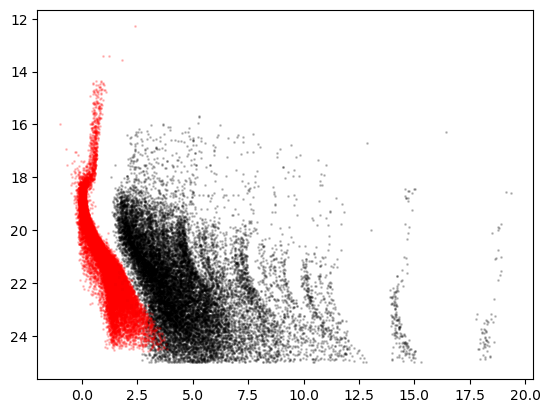

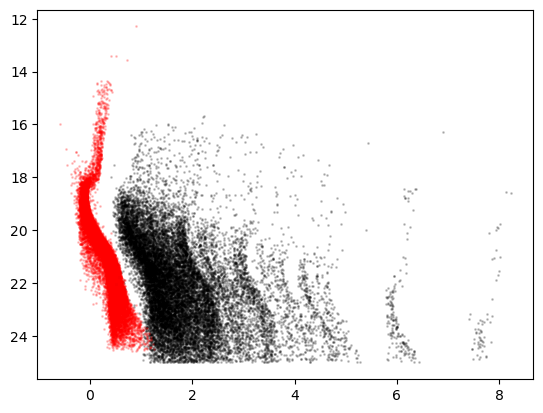

In [162]:
plt.figure()
s='wrf'
plt.plot(scen[s]['Source_R062']-scen[s]['Source_W146'],scen[s]['Source_W146'],
         'ko',ms=1,alpha=0.2)
plt.plot(scen[s]['Source_R062_0']-scen[s]['Source_W146_0'],scen[s]['Source_W146_0'],
         'ro',ms=1,alpha=0.2)
plt.gca().invert_yaxis()
plt.show()
plt.figure()
s='wrf'
plt.plot(scen[s]['Source_Z087']-scen[s]['Source_W146'],scen[s]['Source_W146'],
         'ko',ms=1,alpha=0.2)
plt.plot(scen[s]['Source_Z087_0']-scen[s]['Source_W146_0'],scen[s]['Source_W146_0'],
         'ro',ms=1,alpha=0.2)
plt.gca().invert_yaxis()
plt.show()

t0is all 57.227364389396584
t0is fs_err<0.2 50.47317989656341


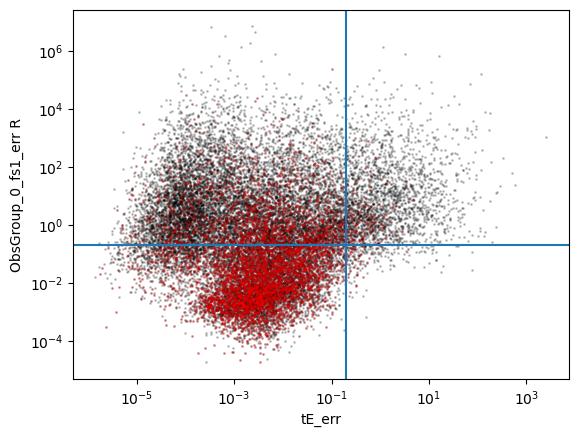

In [123]:
s='wrf'
fsfilter = f'{og[s]}fs{filt["R"]}_err'
t0is = scen[s][(np.abs(scen[s]['u0lens1'])<3) & (scen[s]['u0lens1']>0)]
print("t0is all",t0is['fwc'].sum())
print("t0is fs_err<0.2",t0is[(t0is[fsfilter]<0.2) & (t0is[og[scenario]+'tE_err']<0.2)]['fwc'].sum())
plt.figure()
plt.plot(scen[s][og[s]+'tE_err'],scen[s][fsfilter],'ko',alpha=0.2,ms=1)
plt.plot(t0is[og[scenario]+'tE_err'],t0is[fsfilter],'ro',alpha=0.2,ms=1)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().axvline(x=0.2)
plt.gca().axhline(y=0.2)
plt.xlabel('tE_err')
plt.ylabel(f'{fsfilter} R')
plt.show()

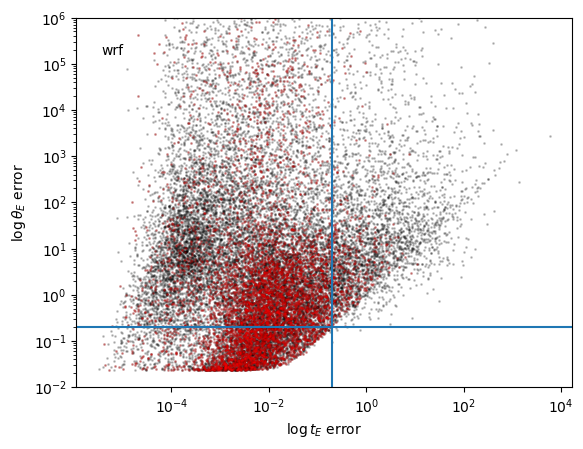

LC thetaE measurements 21.451998496919387  (t0 in season)
LC thetaE measurements 49.72898943116659  (all)


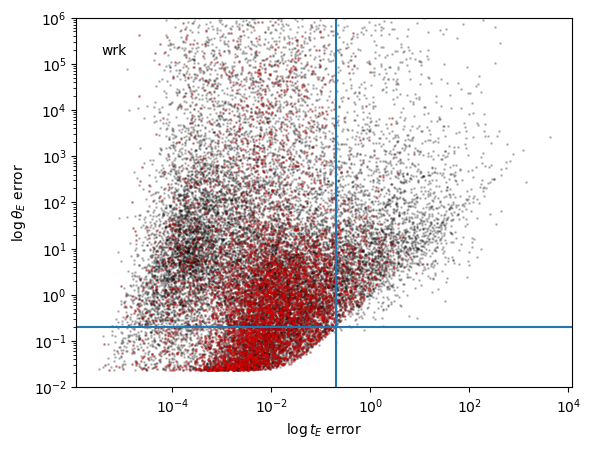

LC thetaE measurements 21.4220541353226  (t0 in season)
LC thetaE measurements 49.70349036391406  (all)


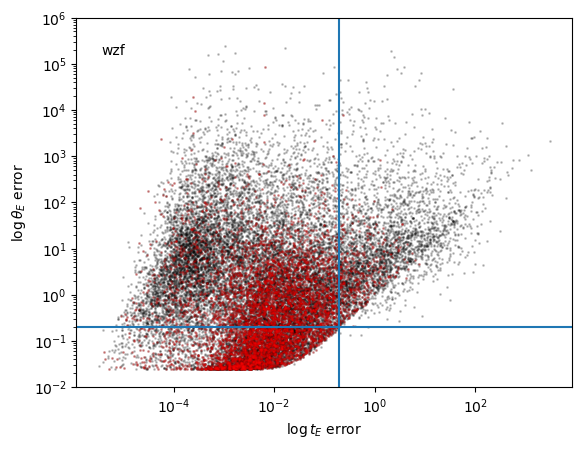

LC thetaE measurements 26.302660304255994  (t0 in season)
LC thetaE measurements 58.98667085748078  (all)


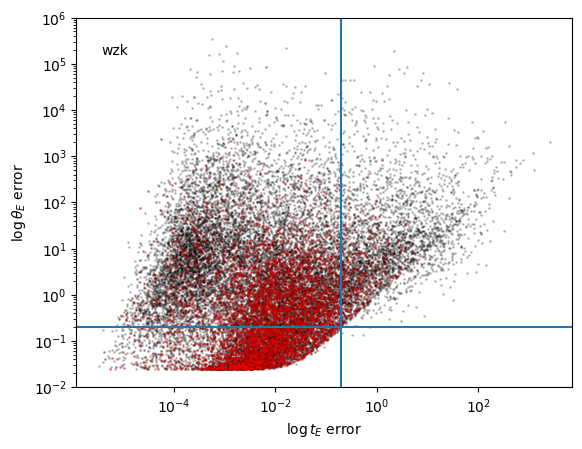

LC thetaE measurements 26.274305618861668  (t0 in season)
LC thetaE measurements 58.89192207376876  (all)


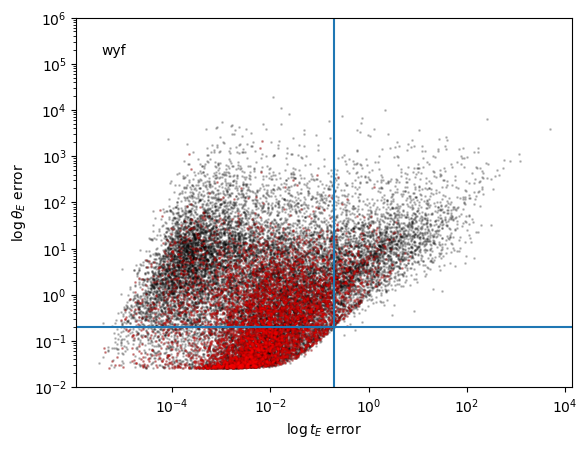

LC thetaE measurements 27.696471807170198  (t0 in season)
LC thetaE measurements 61.56543535408293  (all)


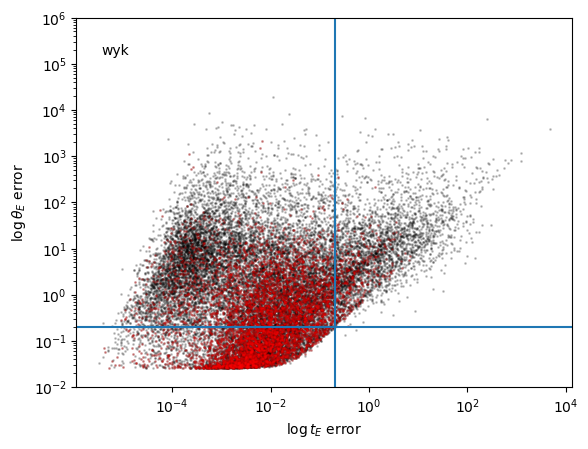

LC thetaE measurements 27.698062355079045  (t0 in season)
LC thetaE measurements 61.42756933763506  (all)


In [124]:
t0is = {}
for s in scenarios:
    fs = f'Obs_{filt[s]}_fs'
    fsfilterr = f'{og[s]}fs{filt[s]}_err'
    rhoerr = f'{og[s]}rs_err'
    t0is[s] = scen[s][(np.abs(scen[s]['u0lens1'])<3) & (scen[s]['u0lens1']>0)]
#    scen[s]["thetae_error"] = np.sqrt(scen[s][rhoerr] 
#                                             + 2.5**2*b[s]**2*(scen[s][fsfilterr]/scen[s][fs]/np.log(10))
#                                             + b[s]**2*0.01**2 + 0.2**2*0.05**2)
    plt.figure()
    plt.plot(np.log(10) * scen[s][og[s]+'tE_err'],scen[s]["thetae_error"],'ko',alpha=0.2,ms=1)
    plt.plot(np.log(10) * t0is[s][og[s]+'tE_err'],t0is[s]["thetae_error"],'ro',alpha=0.2,ms=1)
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.gca().axvline(x=0.2)
    plt.gca().axhline(y=0.2)
    plt.xlabel(r'$\log t_E$ error')
    plt.ylabel(r'$\log \theta_E$ error')
    plt.text(0.05,0.9,s,transform = plt.gca().transAxes)
    plt.ylim([0.01,1e6])
    plt.show()
    
    print("LC thetaE measurements",t0is[s][t0is[s]["thetae_error"]<0.2]['fwc'].sum()," (t0 in season)")
    print("LC thetaE measurements",scen[s][scen[s]["thetae_error"]<0.2]['fwc'].sum()," (all)")

In [131]:
rhoerr = f'{og["wrk"]}rs_err'
t0is['wrk']['thetae_error'].sort_values()

2643     2.335160e-02
8143     2.335693e-02
17859    2.335950e-02
8315     2.337966e-02
7112     2.338309e-02
             ...     
14031    1.188600e+08
6600     1.197508e+08
14014    1.532224e+08
11217    7.952127e+08
7341              NaN
Name: thetae_error, Length: 6482, dtype: float64

# Distributions of fractional precision for $\rho$ and $f_s$ 

Caveat: assumes color surface brightness relations can be applied to all events

wrk
wzk
wyk


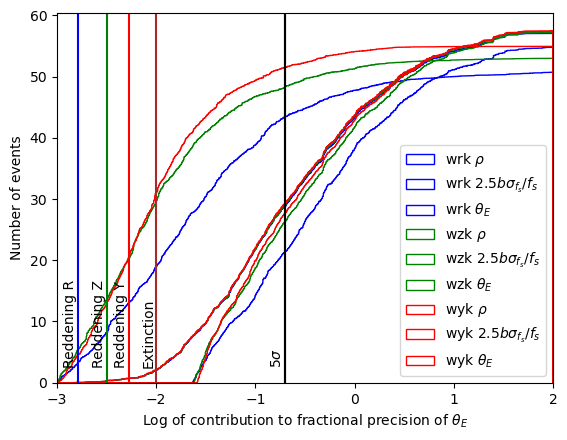

In [134]:
plt.figure()
rstr = r'$\rho$'
thstr = r'$\theta_E$'
pltcol = {'wrk':'blue', 'wzk':'green', 'wyk':'red'}
for s in ['wrk','wzk','wyk']:
    print(s)
    fs = f'Obs_{filt[s]}_fs'
    fsfilterr = f'{og[s]}fs{filt[s]}_err'
    rhoerr = f'{og[s]}rs_err'
    #print(fs,fsfilterr,rhoerr)
    plt.hist(np.log10(np.log(10)*t0is[s][rhoerr]),weights=t0is[s]['fwc'],cumulative=True,
             bins=1000,range=[-3,2],histtype='step',label=f'{s} {rstr}',color=pltcol[s])
    plt.hist(np.log10(np.sqrt(2.5**2*b[s]**2*(t0is[s][fsfilterr]/t0is[s][fs]/np.log(10))**2)),weights=t0is[s]['fwc'],cumulative=True,
             label=f'{s} $2.5b\sigma_{{f_s}}/f_s$',bins=1000,range=[-3,2],histtype='step',
             color=pltcol[s])
    plt.hist(np.log10(t0is[s]['thetae_error']),weights=t0is[s]['fwc'],cumulative=True,
             bins=1000,range=[-3,2],histtype='step',label=f'{s} {thstr}',color=pltcol[s])
plt.gca().axvline(x=np.log10(0.2),c='k')
plt.gca().axvline(x=np.log10(0.2*0.05),c='brown')
plt.text(np.log10(0.2*0.05)-0.15,3,r'Extinction',rotation=90)
plt.gca().axvline(x=np.log10(0.01*b['wyk']),c='red')
plt.text(np.log10(0.01*b['wyk'])-0.15,3,r'Reddening Y',rotation=90)
plt.gca().axvline(x=np.log10(0.01*b['wzk']),c='green')
plt.text(np.log10(0.01*b['wzk'])-0.15,3,r'Reddening Z',rotation=90)
plt.gca().axvline(x=np.log10(0.01*b['wrk']),c='blue')
plt.text(np.log10(0.01*b['wrk'])-0.15,3,r'Reddening R',rotation=90)
plt.gca().axvline(x=np.log10(0.2),c='k')
plt.text(np.log10(0.2)-0.15,3,r'$5\sigma$',rotation=90)
plt.xlim([-3,2])
plt.legend()
plt.ylabel('Number of events')
plt.xlabel(r'Log of contribution to fractional precision of $\theta_E$')
plt.show()

In [ ]:
plt.figure()
for s in ['wrk','wzk']:
    fs = f'Obs_{filt[s]}_fs'
    fsfilterr = f'{og[s]}fs{filt[s]}_err'
    rhoerr = f'{og[s]}rs_err'
    print(fs,fsfilterr,rhoerr)
    plt.hist(np.log10(np.log(10)*t0is[s][rhoerr]),weights=t0is[s]['fwc'],cumulative=True,
             bins=1000,histtype='step',label=f'{s} rho')
    plt.hist(np.log10(np.sqrt(2.5**2*b[s]**2*(t0is[s][fsfilterr]/t0is[s][fs]/np.log(10))**2)),weights=t0is[s]['fwc'],cumulative=True,
             label=f'{s} $2.5b\sigma_{{f_s}}/f_s$',bins=1000,histtype='step')
plt.gca().axvline(x=np.log10(0.2))
plt.xlim([-3,2])
plt.legend()
plt.show()

In [ ]:
over_o_nom = np.zeros(4)
under_o_nom = np.zeros(4)
for i in range(4):
    #print(over[over['EventID']%4==i]['EventID'])
    ov4 = over[over['EventID']%4==i]['fwc'].sum()
    un4 = under[under['EventID']%4==i]['fwc'].sum()
    no4 = nom[nom['EventID']%4==i]['fwc'].sum()
    print(i,ov4,un4,no4)
    over_o_nom[i] = ov4/no4/np.sqrt(4)
    under_o_nom[i] = un4/no4/np.sqrt(4)
print(np.std(over_o_nom),np.std(under_o_nom))

In [ ]:
print(mass[1:],nom['fwc'].sum(),np.sqrt((nom['fwc']**2).sum()),
      under['fwc'].sum(),np.sqrt((under['fwc']**2).sum()),
      over['fwc'].sum(),np.sqrt((over['fwc']**2).sum()),
      over['fwc'].sum()*68.5/70.5,np.sqrt((over['fwc']**2).sum())*68.5/70.5,
      np.std(over_o_nom),np.std(under_o_nom),68.5/70.5*np.std(over_o_nom))

In [ ]:
d = pd.read_csv('/Users/penny/roman/ccsdc_mar2025/bound_det.txt',sep='\s+',
                   names=['massx10','nominal','nominal_err','underguide','underguide_err','overguide','overguide_err','nominal5','nominal5_err','oon_err','uon_err','n5on_err'])
plt.figure()
plt.plot(d['massx10']/10.0,np.ones(d['massx10'].shape),'k-',label='Nominal-6')
plt.errorbar(d['massx10']/10.0,d['underguide']/d['nominal'],yerr=d['uon_err'],fmt='o-',label='Underguide')
plt.errorbar(d['massx10']/10.0,d['overguide']/d['nominal'],yerr=d['oon_err'],fmt='o-',label='Overguide')
plt.errorbar(d['massx10']/10.0,d['nominal5']/d['nominal'],yerr=d['n5on_err'],fmt='o-',label='Nominal-5')
plt.legend()
plt.xlabel(r'$\log(M_{\rm p}/M_{\oplus})$')
plt.ylabel(r'Relative yield of bound planets compared to nominal')
plt.show()

In [ ]:
list(over.columns)

In [ ]:

plt.figure()
plt.hist(over['Source_logg'],weights=over['fwc'],bins=30,alpha=0.5,label="Source")
plt.hist(over['Lens_logg'],weights=over['fwc'],bins=30,alpha=0.5,label="Lens")
plt.legend()
plt.xlabel('log g')
plt.show()

In [ ]:
logg_mr = np.log10(over['Source_Mass'])-2*np.log10(over['Source_Radius'])+4.437
logg_reported = over['Source_logg']
plt.figure()
plt.plot(logg_mr,logg_reported,'ko')
plt.plot([0,6],[0,6],'r-')
plt.show()

# Stop here

In [ ]:
nominal_hist = {}
nominal_err = {}
overguide_hist = {}
underguide_hist = {}
bin_centers = {}
ove_err = {}
und_err = {}

In [ ]:
list(nom.columns)

In [ ]:
plt.figure()
colum='Planet_mass'

rang=[0,4]
nbins=8
if runname == 'willffp_low':
    rang=[-3,0]
    nbins=6

binwidth = (rang[1]-rang[0]+0.0)/nbins


    
#slowlow_hist,bin_edges = np.histogram(np.log10(slowlow[colum]/3.00374072e-6),weights=slowlow['fwc'],bins=nbins) #,range=rang,label='10')
#slowhigh_hist,bin_edges = np.histogram(np.log10(slowhigh[colum]/3.00374072e-6),weights=slowhigh['fwc'],bins=nbins) #,range=rang,label='10')
#fastlow_hist,bin_edges = np.histogram(np.log10(fastlow[colum]/3.00374072e-6),weights=fastlow['fwc'],bins=nbins) #,range=rang,label='10')


#alphaCadence = np.log10(fastlow_hist/slowlow_hist)/np.log10(7.5/14.7315) #* 7*6/0.2**2
#alphatexp = np.log10(slowhigh_hist/slowlow_hist)/np.log10(45.60/42.56) #* 7*6/0.2**2

# /0.5 for bin width
nominal_hist[runname],bin_edges = np.histogram(np.log10(nom[colum]/3.00374072e-6),weights=nom['fwc'],bins=nbins,range=rang)#,label='10')
nominal_err[runname],bin_edges = np.histogram(np.log10(nom[colum]/3.00374072e-6),weights=nom['fwc']**2,bins=nbins,range=rang)#,label='10')

overguide_hist[runname],bin_edges = np.histogram(np.log10(over[colum]/3.00374072e-6),weights=over['fwc'],bins=nbins,range=rang)#,label='10')
underguide_hist[runname],bin_edges = np.histogram(np.log10(under[colum]/3.00374072e-6),weights=under['fwc'],bins=nbins,range=rang)#,label='10')
bin_centers[runname] = 0.5*(bin_edges[1:]+bin_edges[:-1])

nom_hist_sr = {}
ove_hist_sr = {}
und_hist_sr = {}
for sr in range(4):
    nom_sr = nom[nom['SubRun']==sr]
    ove_sr = over[over['SubRun']==sr]
    und_sr = under[under['SubRun']==sr]
    nom_hist_sr[sr],be = np.histogram(np.log10(nom_sr[colum]/3.00374072e-6),weights=nom_sr['fwc'],bins=nbins,range=rang)
    ove_hist_sr[sr],be = np.histogram(np.log10(ove_sr[colum]/3.00374072e-6),weights=ove_sr['fwc'],bins=nbins,range=rang)
    und_hist_sr[sr],be = np.histogram(np.log10(und_sr[colum]/3.00374072e-6),weights=und_sr['fwc'],bins=nbins,range=rang)
    
ove_err[runname] = np.zeros(overguide_hist[runname].shape)
und_err[runname] = np.zeros(underguide_hist[runname].shape)

for sr in range(4):
    ove_err[runname] += (ove_hist_sr[sr]/nom_hist_sr[sr]-overguide_hist[runname]/nominal_hist[runname])**2
    und_err[runname] += (und_hist_sr[sr]/nom_hist_sr[sr]-underguide_hist[runname]/nominal_hist[runname])**2
ove_err[runname] = np.sqrt(ove_err[runname]/4.0)
und_err[runname] = np.sqrt(und_err[runname]/4.0)

#over_ov_nom[runname]

#nominal_mult = (14.9/14.7315)**alphaCadence * (24*3.04/42.56)**alphatexp / binwidth
#overguide_mult = (12.1/14.7315)**alphaCadence * (22*3.04/42.56)**alphatexp / binwidth
#underguide_mult = (12.6/14.7315)**alphaCadence * (19*3.04/42.56)**alphatexp / binwidth

#nominal_hist *= nominal_mult
#overguide_hist *= overguide_mult
#underguide_hist *= underguide_mult



#plt.hist(chunk19[colum],weights=chunk19['final_weight'],bins=100,range=rang,label='19')
#plt.legend()
#plt.yscale('log')
#plt.show()

#chunk10[colum]/3.00374072e-6
plt.figure()
for rn in ['willffp_high','willffp_low']:
    plt.plot(bin_centers[rn],overguide_hist[rn],'ro',label='Overguide')
    plt.plot(bin_centers[rn],underguide_hist[rn],'bo',label='Underguide')#/0.5 for the size of bins
    plt.errorbar(bin_centers[rn],nominal_hist[rn],yerr=np.sqrt(nominal_err[rn]),fmt='ko',label='Nominal')
plt.legend()
plt.xlabel(r'$\log(M_{\rm p}/M_{\oplus})$')
plt.ylabel(r'Detected events per survey per dex mass')
plt.gca().set_yscale('log')
plt.show()

plt.figure()
for rn in ['willffp_high','willffp_low']:
    #if rn == runname:
    plt.errorbar(bin_centers[rn]+0.05,overguide_hist[rn]/nominal_hist[rn],yerr=ove_err[rn],fmt='ro',label='Overguide')
    plt.errorbar(bin_centers[rn],underguide_hist[rn]/nominal_hist[rn],yerr=und_err[rn],fmt='bo',label='Underguide')#/0.5 for the size of bins
    plt.plot(bin_centers[rn],nominal_hist[rn]/nominal_hist[rn],'k-',label='Nominal')
plt.legend()
plt.xlabel(r'$\log(M_{\rm p}/M_{\oplus})$')
plt.ylabel(r'Ratio of yield to nominal survey')
plt.ylim([0.66,1.5])
#plt.gca().set_yscale('log')
plt.show()

In [ ]:
detrates = pd.read_csv(datadir+'%s.det.rates'  % (runname))
detrates = detrates[detrates['ObsGroup_nominal_final_rate']>0]
marker_size = 20
#detrates.columns.tolist()
plt.figure()
plt.scatter(detrates['l_src'],detrates['b_src'],c=detrates['ObsGroup_nominal_final_rate']/0.2**2,
                 marker='s',s=marker_size)

sca = pd.read_csv('/Users/penny/gbtds_optimizer/outline_sca_layout.txt',sep='\s+',header=None)
#fields = pd.read_csv('field_layouts/layout_163000.centers',sep='\s+')
for ff in ['layout_7f_3f_wo407196.covfac.centers','layout_6f_0a_gal-center_89107.covfac.centers','layout_5f_0a_gal-center_40395.covfac.centers']:
    fields = pd.read_csv('/Users/penny/gbtds_optimizer/output/' + ff)

    for i,f in fields.iterrows():
        ls='k-'
        #if f['fixed']==1:
        #    ls='r-'

        plt.plot(sca.iloc[:,1]+f['l'],sca.iloc[:,2]+f['b'],ls)


plt.show()

In [ ]:
over.keys().tolist()

In [ ]:
plt.figure()
plt.hist(nom['Source_Z087'],range=[15,30],cumulative=True,bins=360,weights=nom['fwc'],label='Nominal-6')
plt.hist(over['Source_Z087'],range=[15,30],cumulative=True,bins=360,weights=over['fwc']*68.5/70.5,label='Nominal-5')
plt.title('Source Z087 - ' + mass)
plt.legend()
plt.xlabel('Source Z087')
plt.ylabel('Cumulative number of planet detections')
plt.show()

In [ ]:
plt.figure()
nom6,be = np.histogram(nom['rho']*nom['tE_ref']*24*60*2/14.9,range=[0,21],bins=240,weights=nom['fwc'])
nom5,be = np.histogram(over['rho']*over['tE_ref']*24*60*2/12.1,range=[0,21],bins=240,weights=over['fwc']*68.5/70.5)
plt.plot(0.5*(be[1:]+be[:-1]),nom['fwc'].sum()-nom6.cumsum(),label='Nominal 6')
plt.plot(0.5*(be[1:]+be[:-1]),over['fwc'].sum()*68.5/70.5-nom5.cumsum(),label='Nominal 5')
#/nom5.cumsum())
plt.title(mass)
plt.legend()
plt.grid()
plt.xlabel('Source diameter crossing time/Cadence')
plt.ylabel('Cumulative number of planet detections')
plt.show()

In [ ]:
plt.figure()
nom6,be = np.histogram(nom['Lens_Z087'],range=[15,30],bins=60,weights=nom['fwc'])
nom5,be = np.histogram(over['Lens_Z087'],range=[15,30],bins=60,weights=over['fwc']*68.5/70.5)
plt.plot(0.5*(be[1:]+be[:-1]),nom6.cumsum()/nom5.cumsum())
plt.title('Lens Z087 - ' + mass)
plt.legend()
#plt.
#plt.yscale('log')
plt.ylabel('Cumulative ratio of number of hosts Nominal 6:Nominal 5')
plt.ylim([0,2])
plt.grid()
plt.show()

In [ ]:
plt.figure()
plt.scatter(over['Planet_s'],over['Planet_q'],c='k',alpha=0.2,s=2*over['fwc'])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
plt.figure()
plt.plot(over['ObsGroup_0_chi2'],over['ObsGroup_2_chi2']/over['ObsGroup_0_chi2'],'ko',ms=1,alpha=0.1)
plt.plot([0.1,1.0e9],[1.0,1.0],'r-')
plt.plot([0.1,1.0e9],[0.975,0.975],'b-')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.5,2])
plt.show()

In [ ]:
#from matplotlib.patches import
fig,ax = plt.subplots(2,2,figsize=(10,10))
detrates = pd.read_csv(datadir + 'analysis/%s.det.rates' % (runname))
dr = detrates #[(detrates['l_src']>=-6) & (detrates['l_src']<=6) & (np.abs(detrates['b_src'])>-10) & (np.abs(detrates['b_src'])<=10)]
dr = dr.sort_values(['l_src','b_src'],ascending=[False,True])
dr[f'ObsGroup_nominal_final_rate'] *= 6.0 / 1.7
dr[f'ObsGroup_nominal_final_rate_err'] *= 6.0 / 1.7
dr[f'ObsGroup_overguide_final_rate'] *= 6.0 / 1.7
dr[f'ObsGroup_overguide_final_rate_err'] *= 6.0 / 1.7
dr[f'ObsGroup_underguide_final_rate'] *= 6.0 / 1.7
dr[f'ObsGroup_underguide_final_rate_err'] *= 6.0 / 1.7
#dr['alphaCadence'] = np.log10(dr[f'ObsGroup_Cad7p5_texp42p6_final_rate']/dr[f'ObsGroup_Cad15_texp42p6_final_rate'])/np.log10(7.5/14.7315) #* 7*6/0.2**2
#dr['alphatexp'] = np.log10(dr[f'ObsGroup_Cad15_texp45p7_final_rate']/dr[f'ObsGroup_Cad15_texp42p6_final_rate'])/np.log10(45.60/42.56) #* 7*6/0.2**2


drmap = dr[(dr['l_src']>=-5) & (dr['l_src']<=6.6) & (dr['b_src']>=-4.0) & (dr['b_src']<=4.0)]
drmap = drmap.sort_values(['l_src','b_src'],ascending=[False,True])

#M = ax.transData.get_matrix()
#xscale=M[0,0]
#yscale=M[1,1]

marker_size = 20


#plt.pcolormesh(x,y,z,shading='nearest')
#print(dr['fidu_mass6_rate'])
#print(np.sum(6*7*dr['fidu_mass6_rate']))

#plt.plot(dr['l_src'],dr['alphaCadence'],'ko')
#print("alpha texp",np.nanmedian(dr.alphatexp))
#print("alpha cadence",np.nanmedian(dr.alphaCadence))

p = ax[0,0].scatter(drmap['l_src'],drmap['b_src'],c=drmap['ObsGroup_nominal_final_rate']/0.2**2,
                 marker='s',s=marker_size)

#plt.gca().set_aspect()
ax[0,0].set_aspect('equal')
ax[0,0].set_xlim([6.7,-5.1])
ax[0,0].set_ylim([-4.1,4.1])
ax[0,0].set_xlabel('l (deg)')
ax[0,0].set_ylabel('b (deg)')
fig.colorbar(p,ax=ax[0,0],label=r'$1M_{\oplus}$ FFP Detections/survey/deg$^2$',orientation='horizontal')



pp = ax[1,0].scatter(drmap['l_src'],drmap['b_src'],
                   c=100*drmap['ObsGroup_nominal_final_rate_err']/drmap['ObsGroup_nominal_final_rate'],
                 marker='s',s=marker_size)
ax[1,0].set_aspect('equal')
ax[1,0].set_xlim([6.7,-5.1])
ax[1,0].set_ylim([-4.1,4.1])
ax[1,0].set_xlabel('l (deg)')
ax[1,0].set_ylabel('b (deg)')
fig.colorbar(pp,ax=ax[1,0],label=r'Fractional error (%)',orientation='horizontal')


"""
pp = ax[2,0].scatter(drmap['l_src'],drmap['b_src'],
                   c=drmap['ObsGroup_Cad15_texp45p7_final_rate']/drmap['ObsGroup_Cad15_texp42p6_final_rate'],
                 marker='s',s=marker_size)
ax[2,0].set_aspect('equal')
ax[2,0].set_xlim([6.7,-5.1])
ax[2,0].set_ylim([-4.1,4.1])
ax[2,0].set_xlabel('l (deg)')
ax[2,0].set_ylabel('b (deg)')
fig.colorbar(pp,ax=ax[2,0],label=r'45.7s/42.6s rate',orientation='horizontal')

qq = ax[2,1].scatter(drmap['l_src'],drmap['b_src'],
                   c=drmap['ObsGroup_Cad7p5_texp42p6_final_rate']/drmap['ObsGroup_Cad15_texp42p6_final_rate'],
                 marker='s',s=marker_size)
ax[2,1].set_aspect('equal')
ax[2,1].set_xlim([6.7,-5.1])
ax[2,1].set_ylim([-4.1,4.1])
ax[2,1].set_xlabel('l (deg)')
ax[2,1].set_ylabel('b (deg)')
fig.colorbar(qq,ax=ax[2,1],label=r'7.5min/14.73min rate',orientation='horizontal')
"""



